In [1]:
from scipy.io import loadmat
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import keras

import pandas as pd
import numpy as np

from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.display import clear_output

from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta

sample_size = 20000

Using TensorFlow backend.


`PlotProgress` subclasses the Callback class to plot graph after each epoch

In [2]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="{}".format(self.entity))
        plt.plot(self.x, self.val_losses, label="val_{}".format(self.entity))
        plt.legend()
        plt.show();

Helper functions to extract data from the matlab metadata file and read image from path

In [3]:
def get_date(matlab_datenum):
    matlab_datenum = int(matlab_datenum)
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime

def get_age(row):
    try:
        age = relativedelta(row['photo_taken'], row['dob']).years
    except:
        age = None
    return age

def get_image(path, base='wiki_crop'):
    return io.imread(join(base, path))

### Read and Prepare Data

In [4]:
raw_metadata = loadmat('./wiki_crop/wiki.mat').get('wiki')

In [5]:
flattened_metadata = np.squeeze(np.array([row for data in raw_metadata for rows in data for row in rows]))

### Take only a sample for example

In [6]:
metainfo_df = pd.DataFrame(
    flattened_metadata.T[:sample_size, :4],
    columns = ['dob', 'photo_taken', 'full_path', 'gender'])

In [7]:
metainfo_df['photo_taken'] = metainfo_df.photo_taken.apply(lambda x: datetime(x, 1, 1))
metainfo_df['dob'] = metainfo_df.dob.apply(get_date)
metainfo_df['age'] = metainfo_df.apply(get_age, axis=1)
metainfo_df = metainfo_df[metainfo_df.age > 0]
metainfo_df = metainfo_df[~metainfo_df.gender.isnull()]

In [8]:
metainfo_df.drop(columns=['dob', 'photo_taken'], inplace=True)
metainfo_df.head(), metainfo_df.shape

(                           full_path gender  age
 0  [17/10000217_1981-05-05_2009.jpg]      1   27
 1  [48/10000548_1925-04-04_1964.jpg]      1   38
 2    [12/100012_1948-07-03_2008.jpg]      1   59
 3  [65/10001965_1930-05-23_1961.jpg]      1   30
 4  [16/10002116_1971-05-31_2012.jpg]      0   40, (18847, 3))

In [9]:
%%time
metainfo_df['data'] = metainfo_df.full_path.apply(lambda path_array: get_image(path_array[0]))

CPU times: user 54.2 s, sys: 3.21 s, total: 57.4 s
Wall time: 2min 13s


### Filter images with 3 channels (RGB)

In [10]:
metainfo_df = metainfo_df[metainfo_df.data.apply(lambda x: len(np.shape(x))) == 3]

### Resize images to 100 x 100

In [11]:
%%time
metainfo_df['data'] = metainfo_df.data.apply(lambda img: resize(img, (100, 100), anti_aliasing= True) )

/home/rahul/.environments/tensorflow-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


CPU times: user 4min 7s, sys: 3min 35s, total: 7min 42s
Wall time: 2min 34s


### Check for missing values

In [12]:
metainfo_df.isnull().apply(sum)

full_path    0
gender       0
age          0
data         0
dtype: int64

In [13]:
faces   = np.array([img for img in metainfo_df.data])
labels  = metainfo_df[['age', 'gender']].values

### Split data into train and test

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(faces.astype('float32'), 
                                                      labels.astype('float32'),
                                                      test_size=0.2,
                                                      random_state=123)

In [15]:
y_train_age    = Y_train[:, 0]
y_test_age    = Y_test[:, 0]
y_train_gender = Y_train[:, 1]
y_test_gender = Y_test[:, 1]

In [16]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import plot_model

## Keras Functional API
- This is the main branch
- These layers are common to both the tasks


In [44]:
filter_size = (5, 5)
maxpool_size = (2, 2)
dr = 0.3

inputs = Input(shape=X_train[0].shape, name='main_input')

main_branch = Conv2D(16, kernel_size=filter_size, padding="same")(inputs)
main_branch = Activation("relu")(main_branch)
main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)
main_branch = Dropout(dr)(main_branch)

main_branch = Conv2D(8, kernel_size=filter_size, padding="same")(main_branch)
main_branch = Activation("relu")(main_branch)
main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)
main_branch = Dropout(dr)(main_branch)

main_branch = Flatten()(main_branch)
main_branch = Dense(32)(main_branch)
main_branch = Activation('relu')(main_branch)
main_branch = Dropout(dr)(main_branch)

- This is where the network branches for multiple outputs/tasks
- gender is n x 2 output where as age is n x 1 output

In [45]:
age_branch = Dense(1, activation='relu', name='age_output')(main_branch)
gender_branch = Dense(2, activation='softmax', name='gender_output')(main_branch)

In [46]:
model = Model(inputs = inputs,
     outputs = [age_branch, gender_branch])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 100, 100, 16) 1216        main_input[0][0]                 
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 100, 100, 16) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 50, 50, 16)   0           activation_11[0][0]              
__________________________________________________________________________________________________
dropout_9 

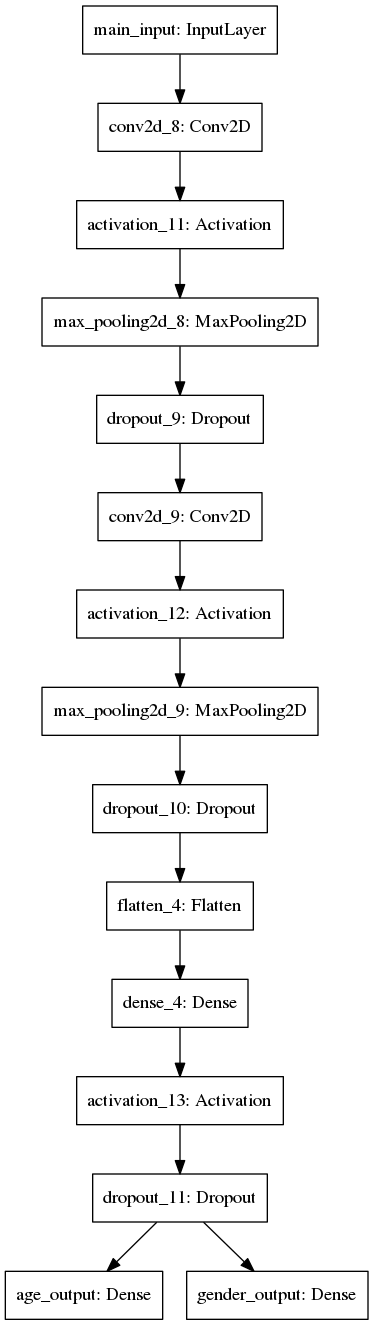

In [47]:
plot_model(model)
Image(retina=True, filename='model.png')

### Multi loss optimizations

- mse for age and cross-entropy for gender
- we can weight these individual losses
- Loss = weight1 * loss1 + weight2 * loss2

In [48]:
opt = keras.optimizers.RMSprop(lr=1e-3)
model.compile(optimizer='rmsprop',
              loss={'age_output': 'mse', 'gender_output': 'sparse_categorical_crossentropy'},
              loss_weights={'age_output': .001, 'gender_output': 1.})

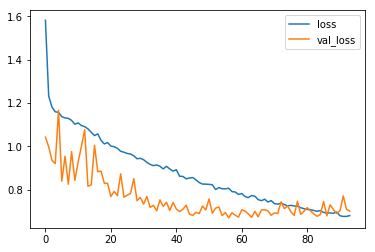

Epoch 95/100
4480/9719 [============>.................] - ETA: 2s - loss: 0.8105 - age_output_loss: 538.3462 - gender_output_loss: 0.2721

In [49]:
plot_progress = PlotProgress(entity='loss')

try:
    model.fit({'main_input': X_train},
              {'age_output': y_train_age, 'gender_output': y_train_gender},
              epochs=100, batch_size=128,
              verbose=1,
              callbacks=[plot_progress],
              validation_split=0.2,
             )
except KeyboardInterrupt:
    pass